## Seung Jun Choi in Urban Information Lab
### Regression Exercise: Bike-Sharing Demand Prediction

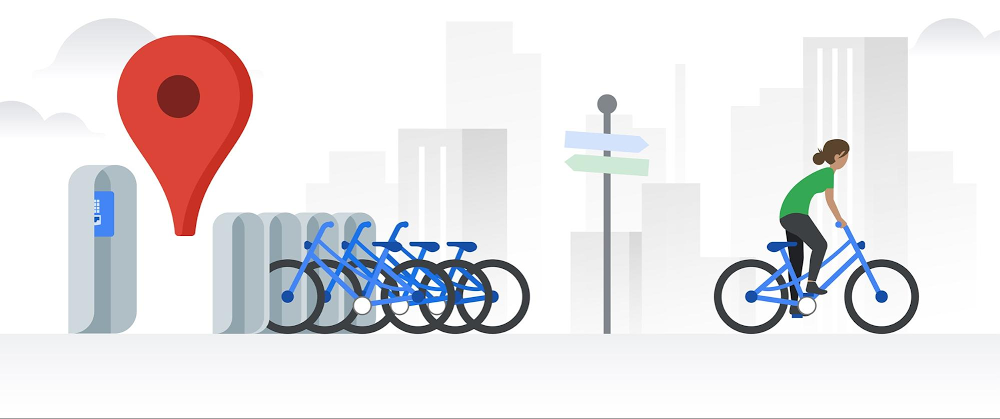

### For those of you unfamiliar with bike-sharing:

### Bike-sharing  is a shared micromobility service in which bicycles are made available for shared use to individuals on a short term basis for a price or free. Many bike share systems allow people to borrow a bike from a "dock" and return it at another dock belonging to the same system.

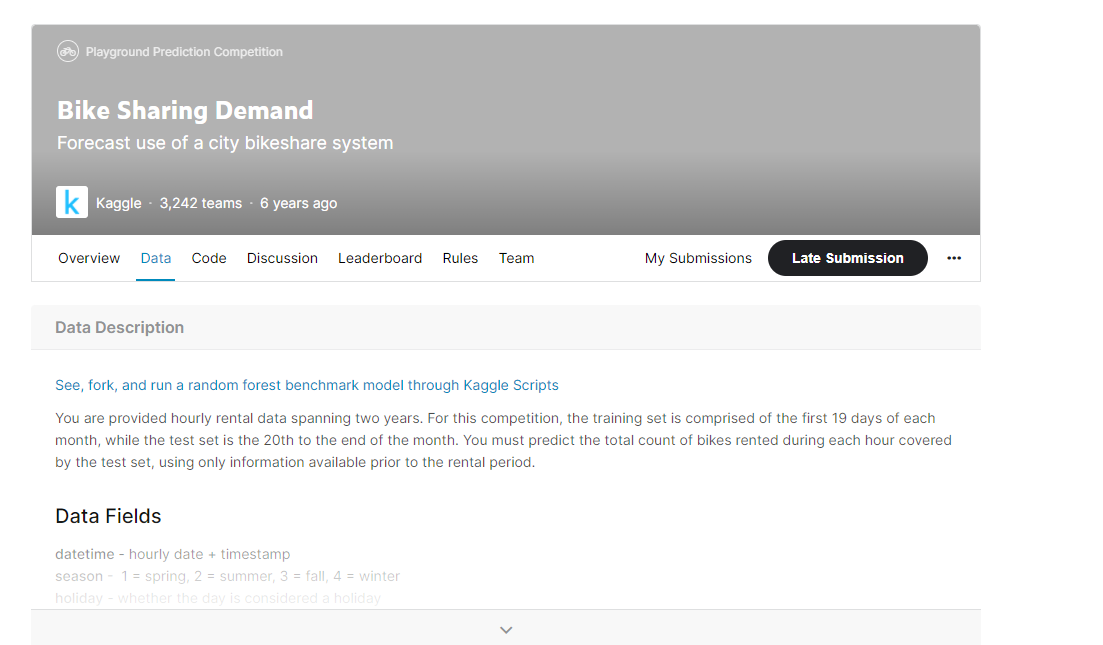

Bike sharing data can be found here on Kaggle: https://www.kaggle.com/competitions/bike-sharing-demand

## 1. Take a look into the data

In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import sys
import warnings
warnings.filterwarnings("ignore", category=RuntimeWarning)

# extra imports only for version printing
import matplotlib
import lightgbm as lgb
import sklearn

print("Python version:", sys.version.split()[0])
print("NumPy version:", np.__version__)
print("Pandas version:", pd.__version__)
print("Seaborn version:", sns.__version__)
print("Matplotlib version:", matplotlib.__version__)
print("LightGBM version:", lgb.__version__)
print("scikit-learn version:", sklearn.__version__)

Python version: 3.11.13
NumPy version: 1.26.4
Pandas version: 2.2.3
Seaborn version: 0.12.2
Matplotlib version: 3.7.2
LightGBM version: 4.5.0
scikit-learn version: 1.2.2


In [3]:
bike_df = pd.read_csv('./bike_train.csv')
print(bike_df.shape)
bike_df.head(3)

(10886, 12)


,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,3,13,16
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,8,32,40
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0,5,27,32


#### It has 10,886 records and includes 12 features/columns

In [4]:
bike_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10886 entries, 0 to 10885
Data columns (total 12 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   datetime    10886 non-null  object 
 1   season      10886 non-null  int64  
 2   holiday     10886 non-null  int64  
 3   workingday  10886 non-null  int64  
 4   weather     10886 non-null  int64  
 5   temp        10886 non-null  float64
 6   atemp       10886 non-null  float64
 7   humidity    10886 non-null  int64  
 8   windspeed   10886 non-null  float64
 9   casual      10886 non-null  int64  
 10  registered  10886 non-null  int64  
 11  count       10886 non-null  int64  
dtypes: float64(3), int64(8), object(1)
memory usage: 1020.7+ KB


#### The features are mostly numeric; however, the 'datetime' column is currently an object datatype. To use this as a date, we need to convert it to a datetime object. For plotting and further anlaysis, we extract the year, month, day, and hour into new columns:

In [5]:
# Assign datetime into datetime type
bike_df['datetime'] = bike_df.datetime.apply(pd.to_datetime)

# From the datetime assign year, month, day, and hour
bike_df['year'] = bike_df.datetime.apply(lambda x : x.year)
bike_df['month'] = bike_df.datetime.apply(lambda x : x.month)
bike_df['day'] = bike_df.datetime.apply(lambda x : x.day)
bike_df['hour'] = bike_df.datetime.apply(lambda x: x.hour)
bike_df.head(3)

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count,year,month,day,hour
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,3,13,16,2011,1,1,0
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,8,32,40,2011,1,1,1
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0,5,27,32,2011,1,1,2


In [7]:
bike_df.shape

(10886, 16)

#### Now four new features are added (year, month, day, hour)

#### However, it seems some of the data is redundant. The count feature is actually the sum of casual and registered bike sharing use. So we are going to delete those features.

In [8]:
drop_columns = ['datetime','casual','registered']
bike_df.drop(drop_columns, axis=1,inplace=True)

#### To evaluate regression models we use...

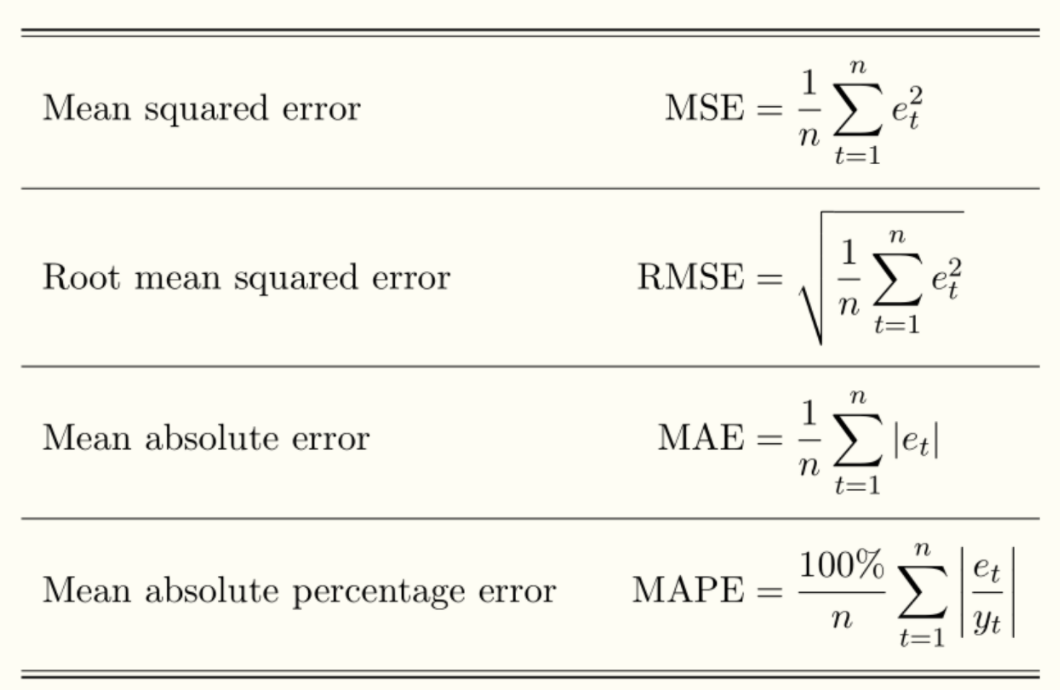

In [9]:
# We use sklearn.metrics and import the modules for evaluation
from sklearn.metrics import mean_squared_error, mean_absolute_error

# However, one thing that we should keep in mind is that Sckit learn does not offer RMSLE (Root Mean Suqared Log Error) 
# until version 1.4 (if you have this later version, it can be found as root_mean_squared_log_error in sklearn.metrics)
# We have manually defined RMSLE as below:
def rmsle(y, pred):
    log_y = np.log1p(y)
    log_pred = np.log1p(pred)
    squared_error = (log_y - log_pred) ** 2
    rmsle = np.sqrt(np.mean(squared_error))
    return rmsle

In [10]:
# RMSE
def rmse(y,pred):
    # just the square root of the mean squared error
    return np.sqrt(mean_squared_error(y,pred))

In [11]:
# MSE, RMSE, RMSLE 
def evaluate_regr(y,pred):
    rmsle_val = rmsle(y,pred)
    rmse_val = rmse(y,pred)
    
    # MAE function already exists in sklearn modules
    mae_val = mean_absolute_error(y,pred)
    print('RMSLE: {0:.3f}, RMSE: {1:.3F}, MAE: {2:.3F}'.format(rmsle_val, rmse_val, mae_val))

## 2. Modeling
### Let's use linear regression first

In [41]:
from sklearn.model_selection import train_test_split , GridSearchCV
from sklearn.linear_model import LinearRegression , Ridge , Lasso

y_target = bike_df['count']
X_features = bike_df.drop(['count'],axis=1,inplace=False)

X_train, X_test, y_train, y_test = train_test_split(X_features, y_target, test_size=0.3, random_state=0)

lr_reg = LinearRegression()
lr_reg.fit(X_train, y_train)
pred = lr_reg.predict(X_test)

evaluate_regr(y_test ,pred)

RMSLE: 1.165, RMSE: 140.900, MAE: 105.924


#### Considering the bike-sharing counts, the error is a bit high

In [42]:
bike_df['count'].describe()

count    10886.000000
mean       191.574132
std        181.144454
min          1.000000
25%         42.000000
50%        145.000000
75%        284.000000
max        977.000000
Name: count, dtype: float64

#### So let's compare the prediction with actual data

In [43]:
def get_top_error_data(y_test, pred, n_tops = 5):
    # Comparing predictions with actual counts
    result_df = pd.DataFrame(y_test.values, columns=['real_count'])
    result_df['predicted_count']= np.round(pred)
    result_df['diff'] = np.abs(result_df['real_count'] - result_df['predicted_count'])
    # Pulling them out in order
    print(result_df.sort_values('diff', ascending=False)[:n_tops])
    
get_top_error_data(y_test,pred,n_tops=5)

      real_count  predicted_count   diff
1618         890            322.0  568.0
3151         798            241.0  557.0
966          884            327.0  557.0
412          745            194.0  551.0
2817         856            310.0  546.0


#### Recall the average bike-sharing count was 191 and median was 145. A prediction gap greater than 500 does not seem to fit well

## This is because the bike-sharing count is skewed right, with most values concentrated on the lower end

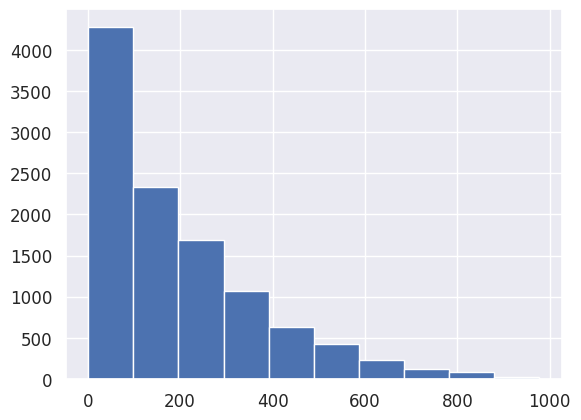

In [45]:
y_target.hist()
plt.show()

### Let's take a log of our data

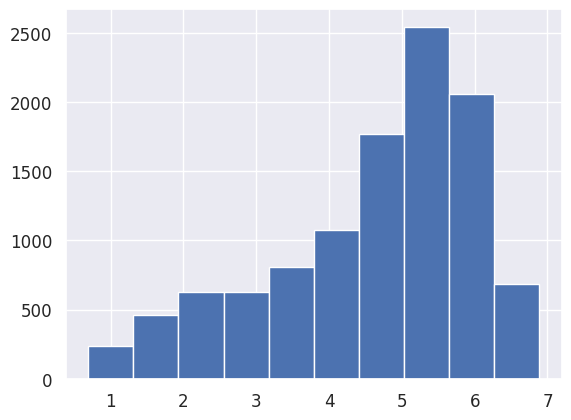

In [46]:
y_log_transform = np.log1p(y_target)
y_log_transform.hist()
plt.show()

#### Now it seems the target more closely follows a more normalized distribution. Let's retrain the linear model.

In [47]:

y_target_log = np.log1p(y_target)

X_train, X_test, y_train, y_test = train_test_split(X_features, y_target_log, test_size=0.3, random_state=0)
lr_reg = LinearRegression()
lr_reg.fit(X_train, y_train)
pred = lr_reg.predict(X_test)

y_test_exp = np.expm1(y_test)

pred_exp = np.expm1(pred)

evaluate_regr(y_test_exp ,pred_exp)

RMSLE: 1.017, RMSE: 162.594, MAE: 109.286


#### The RMSLE score decreased; however, RMSE increased. What's happening here?

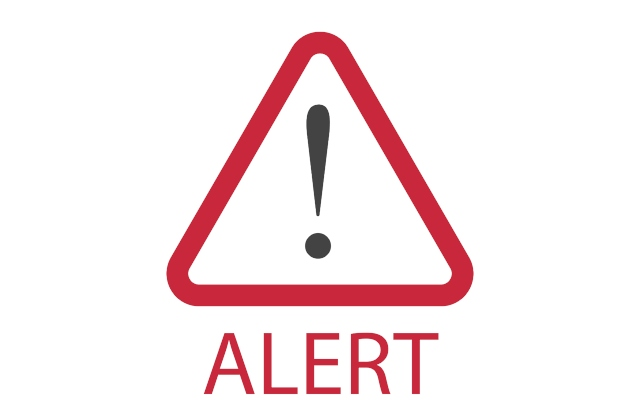

## 3. Model Validation

### Take a look at the feature coefficients

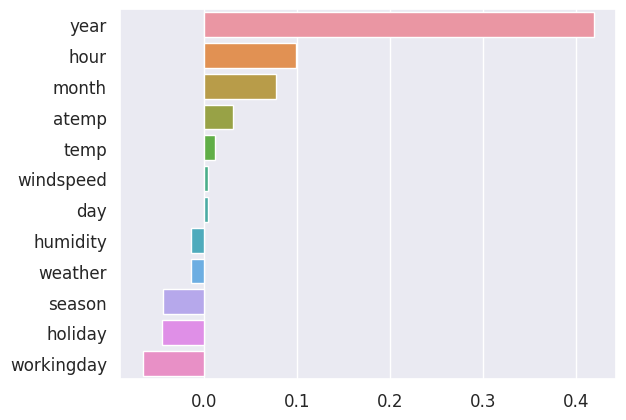

In [48]:
coef = pd.Series(lr_reg.coef_, index=X_features.columns)
coef_sort = coef.sort_values(ascending=False)
sns.barplot(x=coef_sort.values, y=coef_sort.index)
plt.show()

### Datetime features (including year, hour, and month) have the largest coefficients.
### The data is only from year 2011 and 2012, so the fact that 'year' has the highest coefficient does not make sense. 
### This is happening because 'year' is stored as an integer and the large values are affecting the training. 
### However, 'year' actually represents a categorical variable

### -> One Hot Encoding

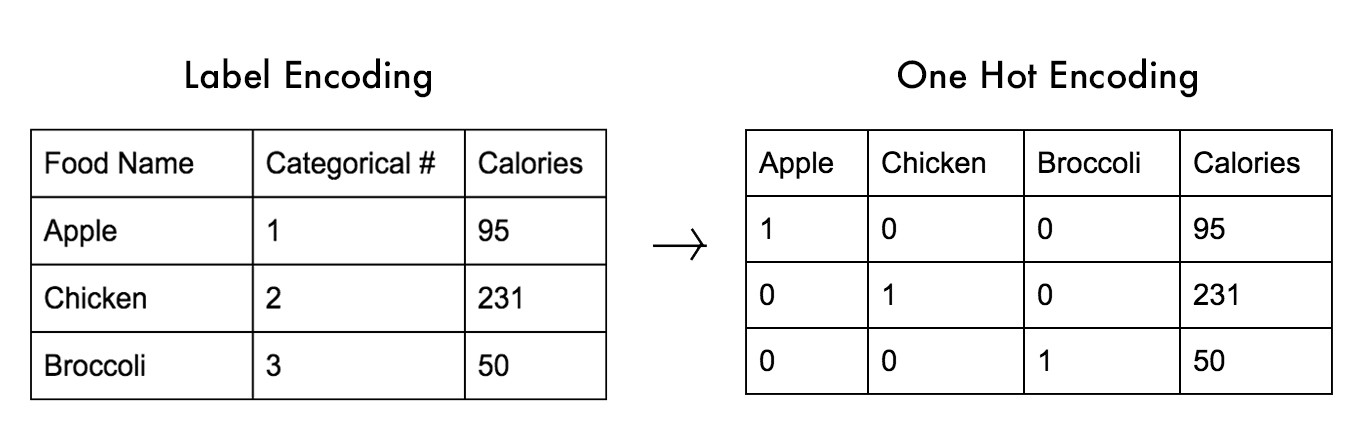

The features 'year', 'month', 'day', and 'hour' are just labels that represent a date and time. For example, year 2012 does not have a greater value than year 2011. The same is true for the features 'holiday', 'workingday', 'season', and 'weather', so we use one-hot encoding:

In [30]:
# 'year', month', 'day', hour', 'holiday', 'workingday', 'season', 'weather' -> One hot encoding
X_features_ohe = pd.get_dummies(X_features, columns=['year', 'month','day', 'hour', 'holiday',
                                              'workingday','season','weather'])

### Retrain your data after one-hot encoding
#### We'll be modeling with Ridge and Lasso too

In [33]:
X_train, X_test, y_train, y_test = train_test_split(X_features_ohe, y_target_log,
                                                    test_size=0.3, random_state=0)

# Error Scores
def get_model_predict(model, X_train, X_test, y_train, y_test, is_expm1=False):
    model.fit(X_train, y_train)
    pred = model.predict(X_test)
    if is_expm1 :
        y_test = np.expm1(y_test)
        pred = np.expm1(pred)
    print('###',model.__class__.__name__,'###')
    evaluate_regr(y_test, pred)

# model evaluation
lr_reg = LinearRegression()
ridge_reg = Ridge(alpha=10)
lasso_reg = Lasso(alpha=0.01)

for model in [lr_reg, ridge_reg, lasso_reg]:
    get_model_predict(model,X_train, X_test, y_train, y_test,is_expm1=True)


### LinearRegression ###
RMSLE: 0.590, RMSE: 97.688, MAE: 63.382
### Ridge ###
RMSLE: 0.590, RMSE: 98.529, MAE: 63.893
### Lasso ###
RMSLE: 0.635, RMSE: 113.219, MAE: 72.803


## Do you see the difference?

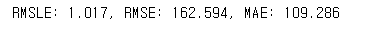

### Replot coefficients

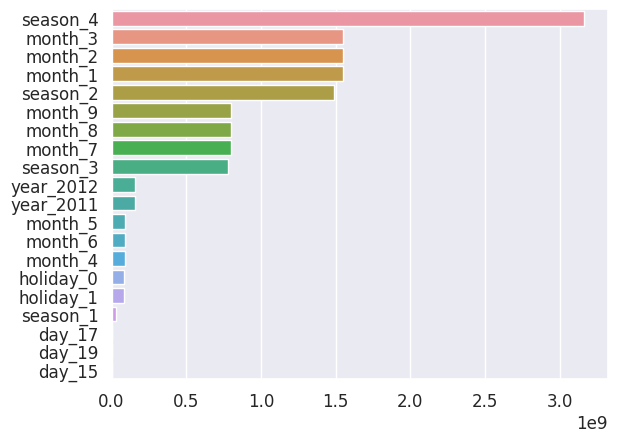

In [38]:
coef = pd.Series(lr_reg.coef_ , index=X_features_ohe.columns)
coef_sort = coef.sort_values(ascending=False)[:20]
sns.barplot(x=coef_sort.values , y=coef_sort.index)
plt.show()

## In linear models, feature values have a huge impact, so ensure you handle categorical variables appropriately

## +Bonus, We'll train Decision Tree based regression models too

In [35]:
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor

# RandomForest, GBM, XGBoost, LightGBM model 
rf_reg = RandomForestRegressor(n_estimators=500)
gbm_reg = GradientBoostingRegressor(n_estimators=500)
xgb_reg = XGBRegressor(n_estimators=500)
lgbm_reg = LGBMRegressor(n_estimators=500)

for model in [rf_reg, gbm_reg, xgb_reg, lgbm_reg]:
    # XGBoost may not work if your input is a DataFrame, so pass in an ndarray
    get_model_predict(model,X_train.values, X_test.values, y_train.values, y_test.values,is_expm1=True)

### RandomForestRegressor ###
RMSLE: 0.354, RMSE: 50.179, MAE: 31.069
### GradientBoostingRegressor ###
RMSLE: 0.330, RMSE: 53.339, MAE: 32.741
### XGBRegressor ###
RMSLE: 0.339, RMSE: 51.475, MAE: 31.357
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001994 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 348
[LightGBM] [Info] Number of data points in the train set: 7620, number of used features: 72
[LightGBM] [Info] Start training from score 4.582043
### LGBMRegressor ###
RMSLE: 0.319, RMSE: 47.215, MAE: 29.029


#### The error scores are lower for the Decision Tree models than for the linear models. However, this does not necessarily mean that a Decision Tree model is performing better than linear models.

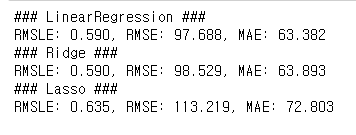

## Ultimately, the model performance depends on features and how we setup & preprocess those features

### In Decision Tree models and classification models (both linear + nonlinear) you can pull out feature importances

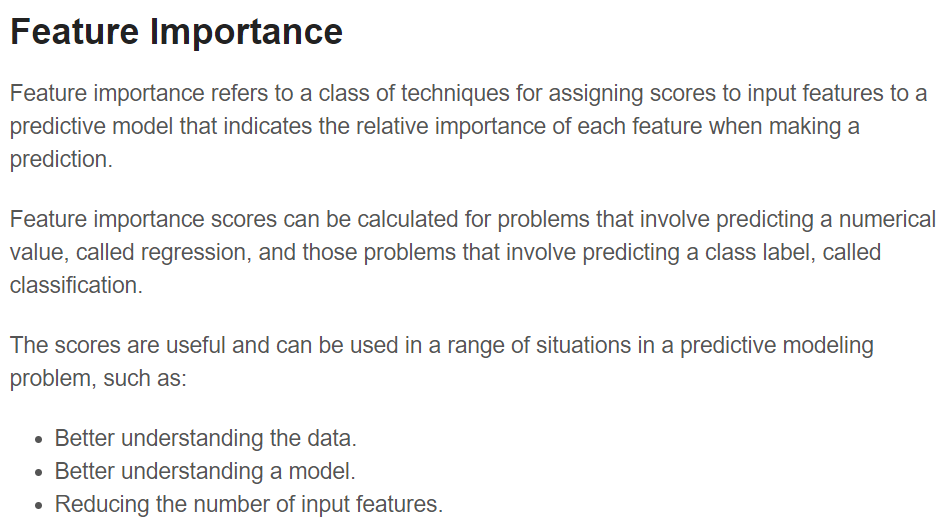

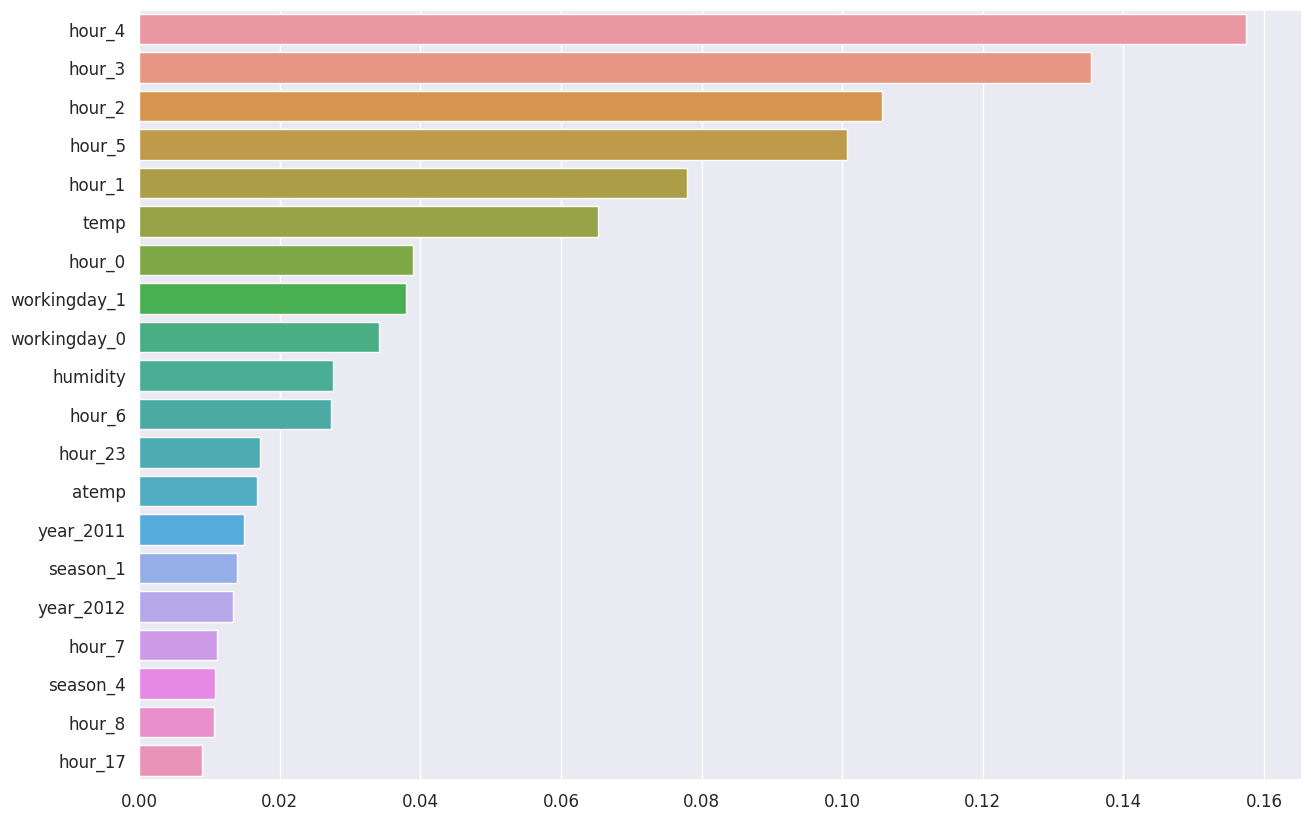

In [39]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from matplotlib import font_manager, rc
# font_path = "C:/Windows/Fonts/NanumBarunGothic.TTF"
# font = font_manager.FontProperties(fname=font_path).get_name()
# rc('font', family=font)

ftr_importances_values = rf_reg.feature_importances_
ftr_importances = pd.Series(ftr_importances_values,index=X_train.columns  )
ftr_top20 = ftr_importances.sort_values(ascending=False)[:20]

plt.figure(figsize=(15,10))
sns.barplot(x=ftr_top20 , y = ftr_top20.index)
sns.set(font_scale=1.1)
plt.show()

## This can be helpful information for policymakers. For bike-sharing, we can observe that certain times of day and climate factors have a high feature importance.
## But, be careful interpreting the feature importances if the data or your model is biased... 

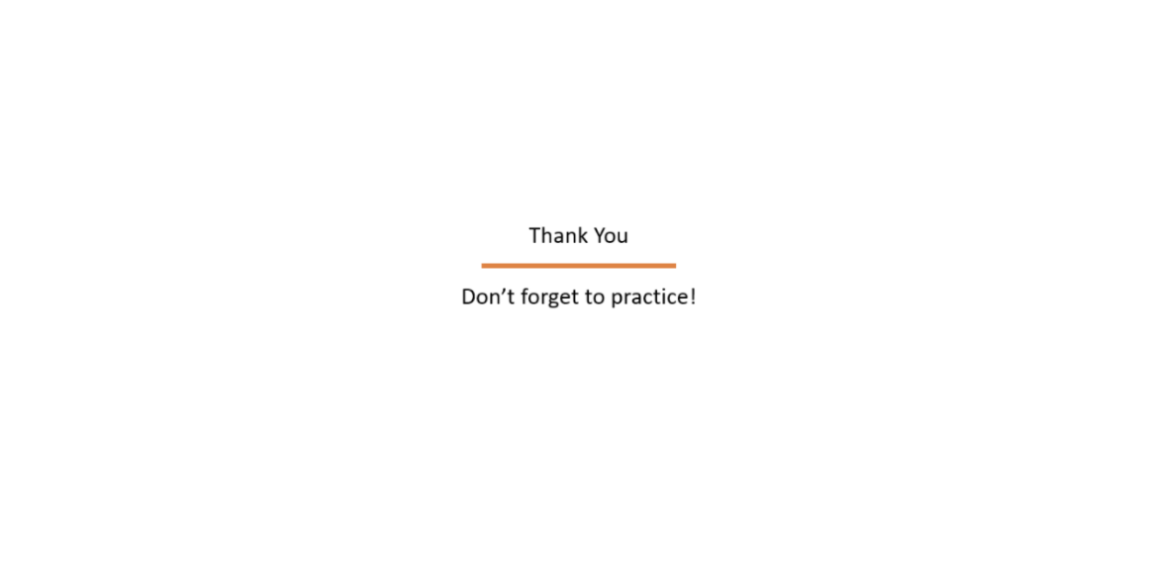